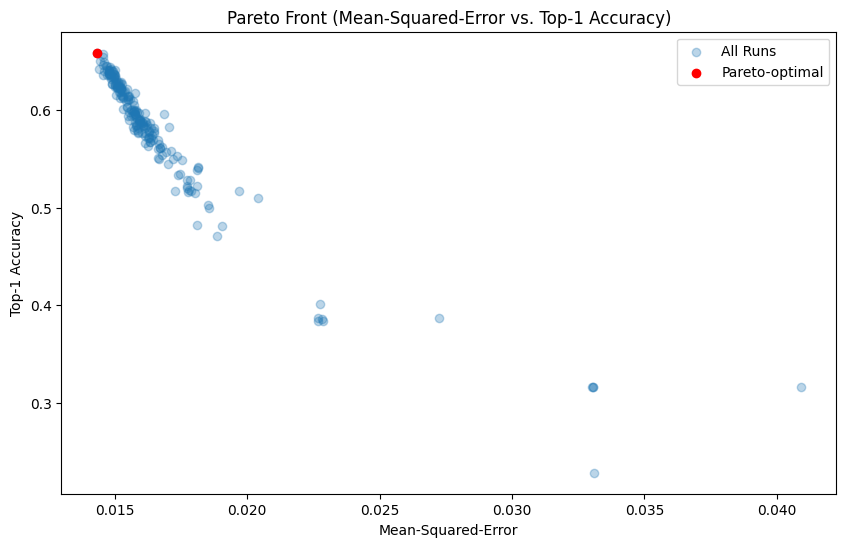

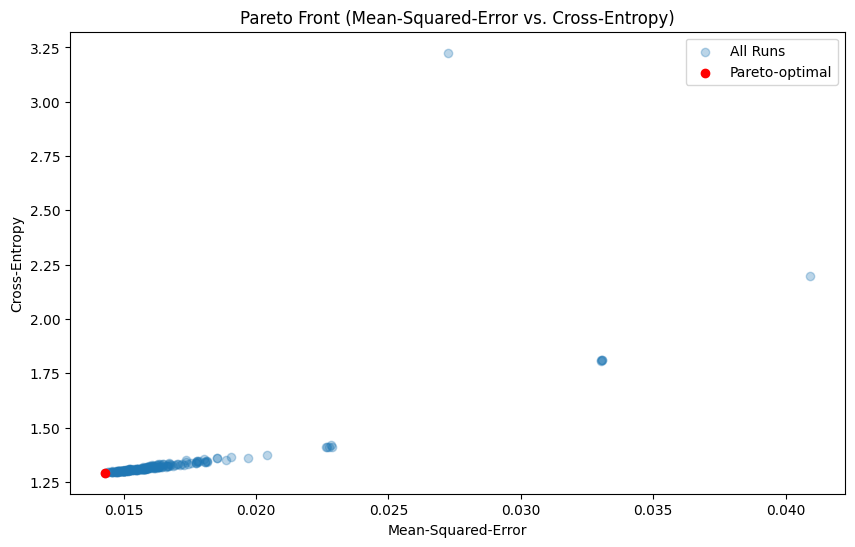

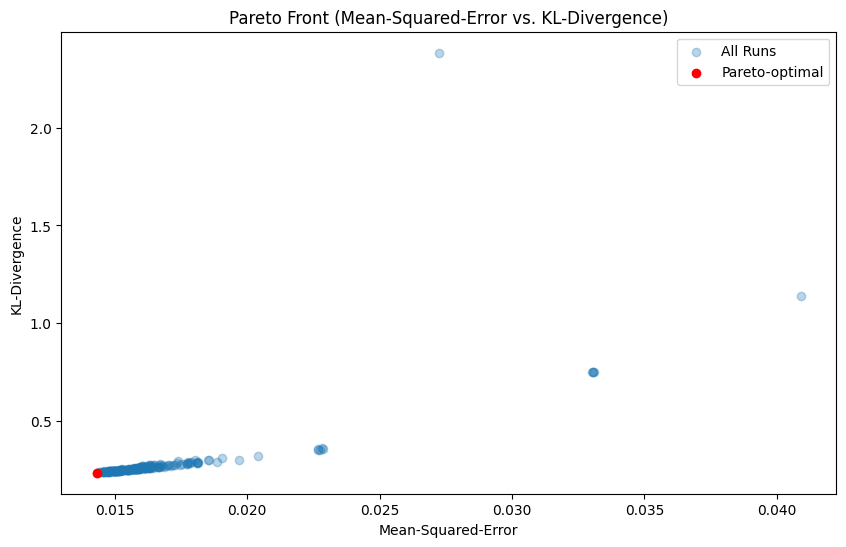

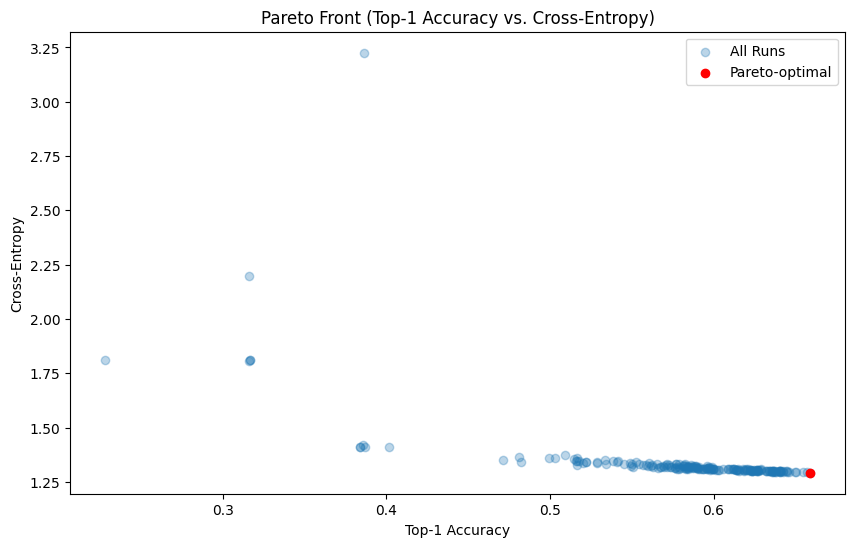

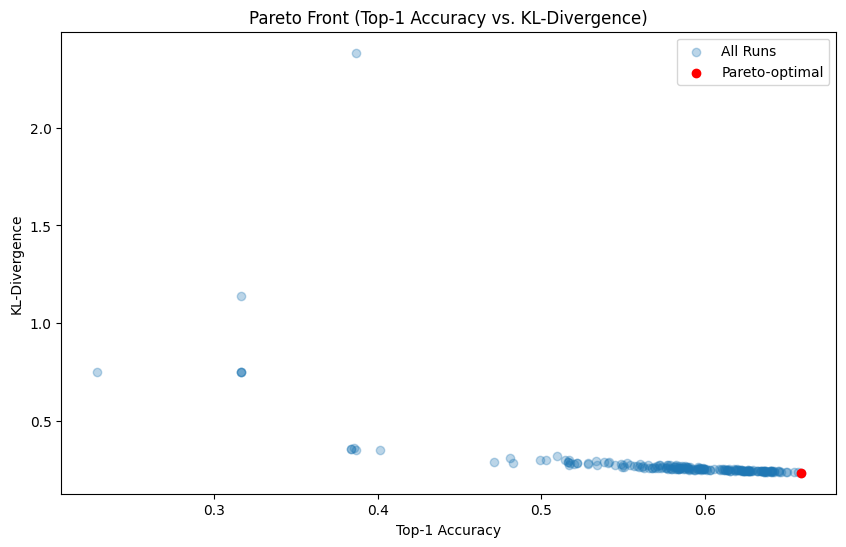

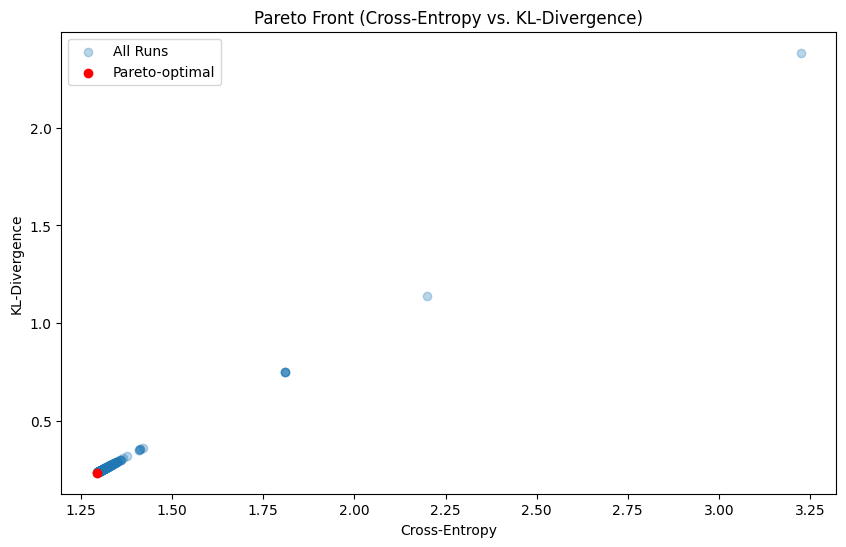

In [5]:
import ray
from ray import tune
from ray.tune import ExperimentAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
prettify={"mse":"Mean-Squared-Error","topk":"Top-1 Accuracy","ce":"Cross-Entropy","kl":"KL-Divergence"}

def compute_pareto(df, metric1, metric2, mode1="min", mode2="max"):
    is_optimal = np.ones(len(df), dtype=bool)
    for i,row in df.iterrows():
        for j,other in df.iterrows():
            if i==j:
                continue
            #Compare row to other: if other is as good or better in both metrics (and strictly better in one)
            cond1=(other[metric1]<=row[metric1] if mode1=="min" else other[metric1]>=row[metric1])
            cond2=(other[metric2]>=row[metric2] if mode2=="max" else other[metric2]<=row[metric2])
            if cond1 and cond2 and (other[metric1]!=row[metric1] or other[metric2]!=row[metric2]):
                is_optimal[i]=False
                break
    return is_optimal

analysis=ExperimentAnalysis(r"C:\Users\Tristan\Downloads\HyPCAR3\ray_results\ray_tune_multi_objective")
df=analysis.dataframe()


possible=[("mse","min"),("topk","max"),("ce","min"),("kl","min")]
for (metric1, mode1), (metric2, mode2) in combinations(possible, 2):
    if metric1!=metric2:


        pareto_mask=compute_pareto(df, metric1, metric2, mode1=mode1, mode2=mode2)
        df_pareto=df[pareto_mask]

        plt.figure(figsize=(10, 6))
        plt.scatter(df[metric1], df[metric2], alpha=0.3, label="All Runs")
        plt.scatter(df_pareto[metric1], df_pareto[metric2], color="red", label="Pareto-optimal")
        plt.xlabel(f"{prettify[metric1]}")
        plt.ylabel(f"{prettify[metric2]}")
        plt.title(f"Pareto Front ({prettify[metric1]} vs. {prettify[metric2]})")
        plt.legend()
        filePath="paretoFront_"+metric1+"_vs_"+metric2+".png"
        plt.savefig(filePath)
        plt.show()

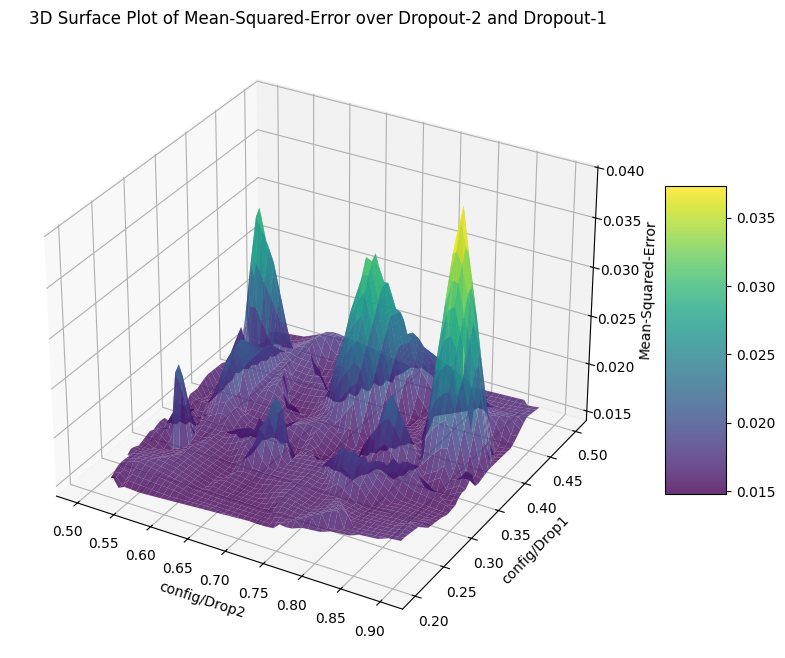

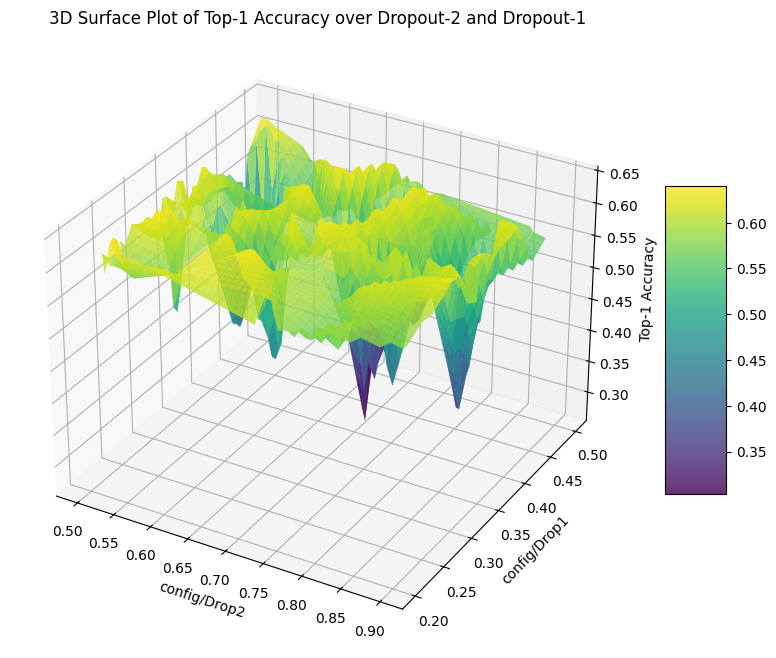

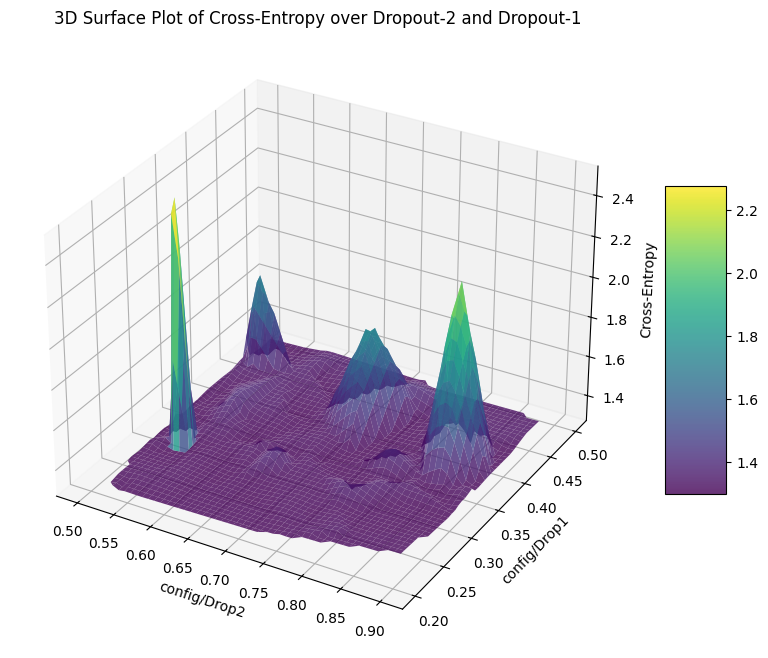

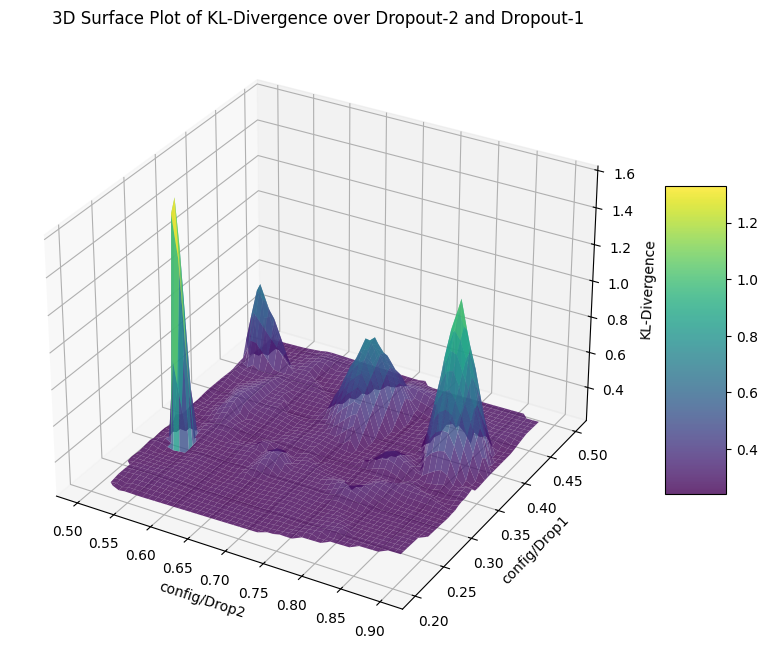

In [18]:
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata

for metric in ["mse","topk","ce","kl"]:
    x_param="config/Drop2"
    y_param="config/Drop1"

    #Create grid points
    x_vals=np.linspace(df[x_param].min(),df[x_param].max(), 50)
    y_vals=np.linspace(df[y_param].min(),df[y_param].max(), 50)
    X,Y=np.meshgrid(x_vals, y_vals)

    #Interpolate the metric values on the grid
    points=df[[x_param, y_param]].values
    values=df[metric].values
    Z=griddata(points,values,(X, Y),method='linear')
    # print(Z)

    fig=plt.figure(figsize=(10, 8))
    ax=fig.add_subplot(111, projection='3d')
    surf=ax.plot_surface(X, Y, Z, cmap=cm.viridis, edgecolor='none', alpha=0.8)
    ax.set_xlabel(x_param)
    ax.set_ylabel(y_param)
    ax.set_zlabel(prettify[metric])
    ax.set_title("3D Surface Plot of {} over Dropout-2 and Dropout-1".format(prettify[metric]))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    filePath="3D_surface_"+metric+".png"
    plt.savefig(filePath)
    plt.show()

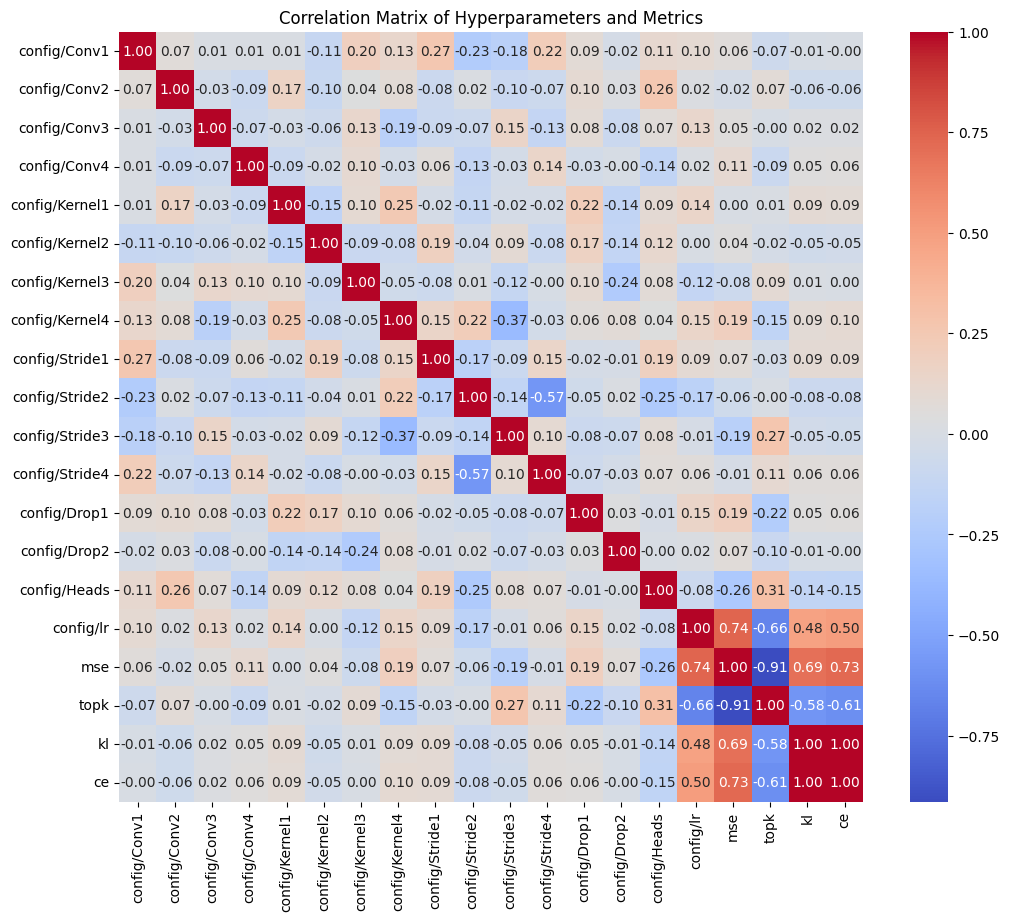

In [20]:
import seaborn as sns

# Select hyperparameter columns and metrics columns
columns = [col for col in df.columns if col.startswith("config/")] + ["mse", "topk", "kl", "ce"]
corr = df[columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Hyperparameters and Metrics")
plt.savefig("hyperparameterCorrelation.png")
plt.show()

C:\Users\Tristan\AppData\Local\Temp\ipykernel_5716\1906953171.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="parameter", data=importance_df, palette="viridis")


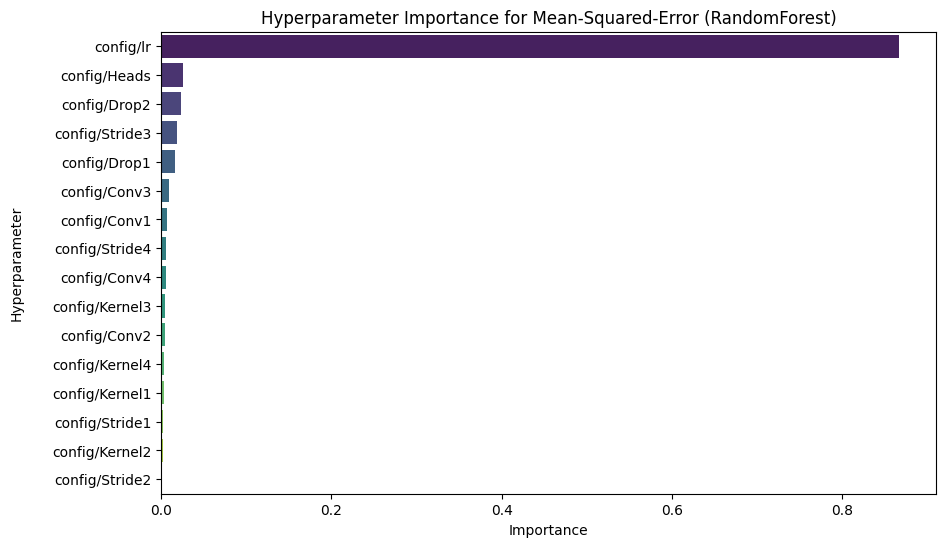

C:\Users\Tristan\AppData\Local\Temp\ipykernel_5716\1906953171.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="parameter", data=importance_df, palette="viridis")


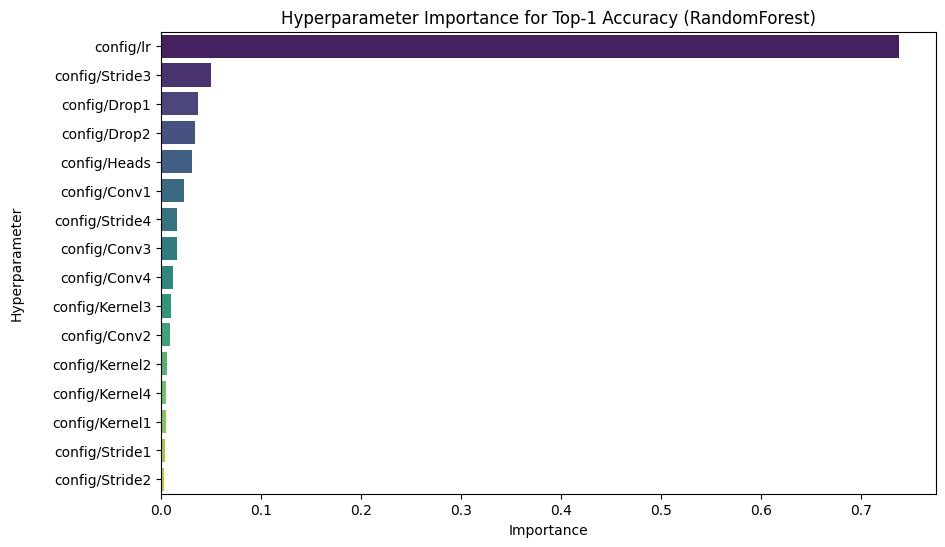

C:\Users\Tristan\AppData\Local\Temp\ipykernel_5716\1906953171.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="parameter", data=importance_df, palette="viridis")


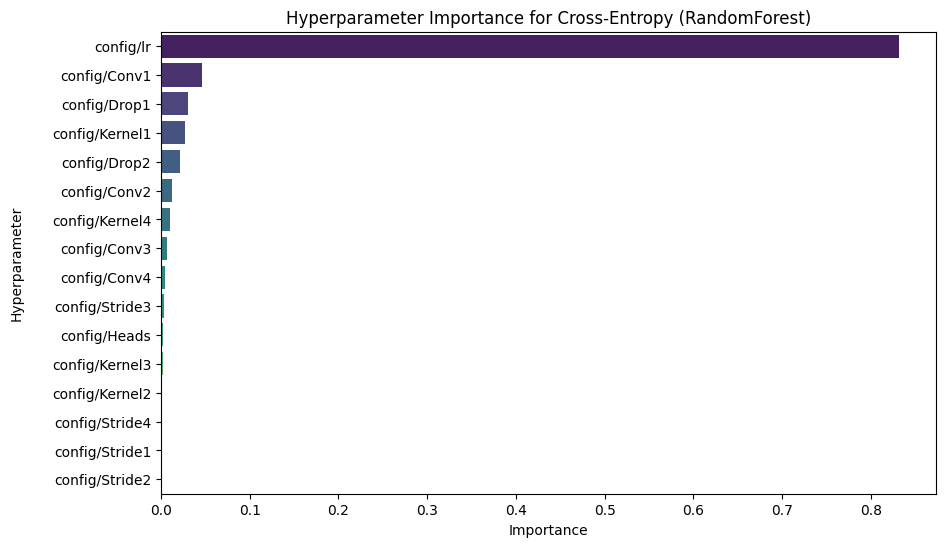

C:\Users\Tristan\AppData\Local\Temp\ipykernel_5716\1906953171.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="parameter", data=importance_df, palette="viridis")


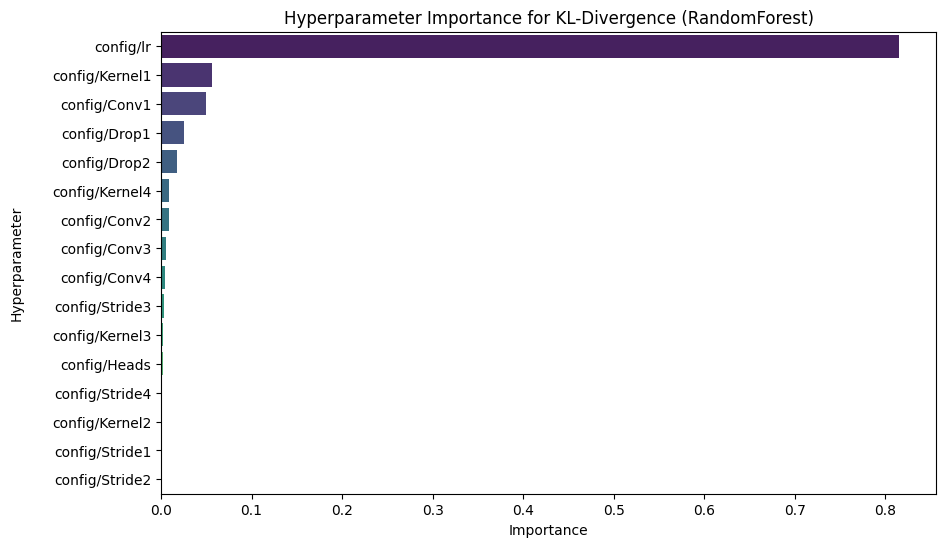

: 

In [ ]:
#Random forest relation

from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
for metric in ["mse","topk","ce","kl"]:

    param_columns=[col for col in df.columns if col.startswith("config/")] 
    X=df[param_columns]
    y=df[metric] 

    #Train a Random Forest regressor
    rf=RandomForestRegressor(n_estimators=1000, random_state=42)
    rf.fit(X, y)
    importances=rf.feature_importances_

    # Create a DataFrame for plotting
    importance_df=pd.DataFrame({"parameter": param_columns, "importance": importances})
    importance_df.sort_values("importance", ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="parameter", data=importance_df, palette="viridis")
    plt.title(f"Hyperparameter Importance for {prettify[metric]} (RandomForest)")
    plt.xlabel("Importance")
    plt.ylabel("Hyperparameter",labelpad=20)

    filePath="importance_"+metric+".png"

    plt.savefig(filePath,bbox_inches="tight")
    plt.show()
